In [2]:
import json
with open('data/aguvis/train/seeclick.json', 'r') as f:
    data = json.load(f)

In [3]:
len(data)

271121

In [4]:
data[0].keys()

dict_keys(['image', 'conversations'])

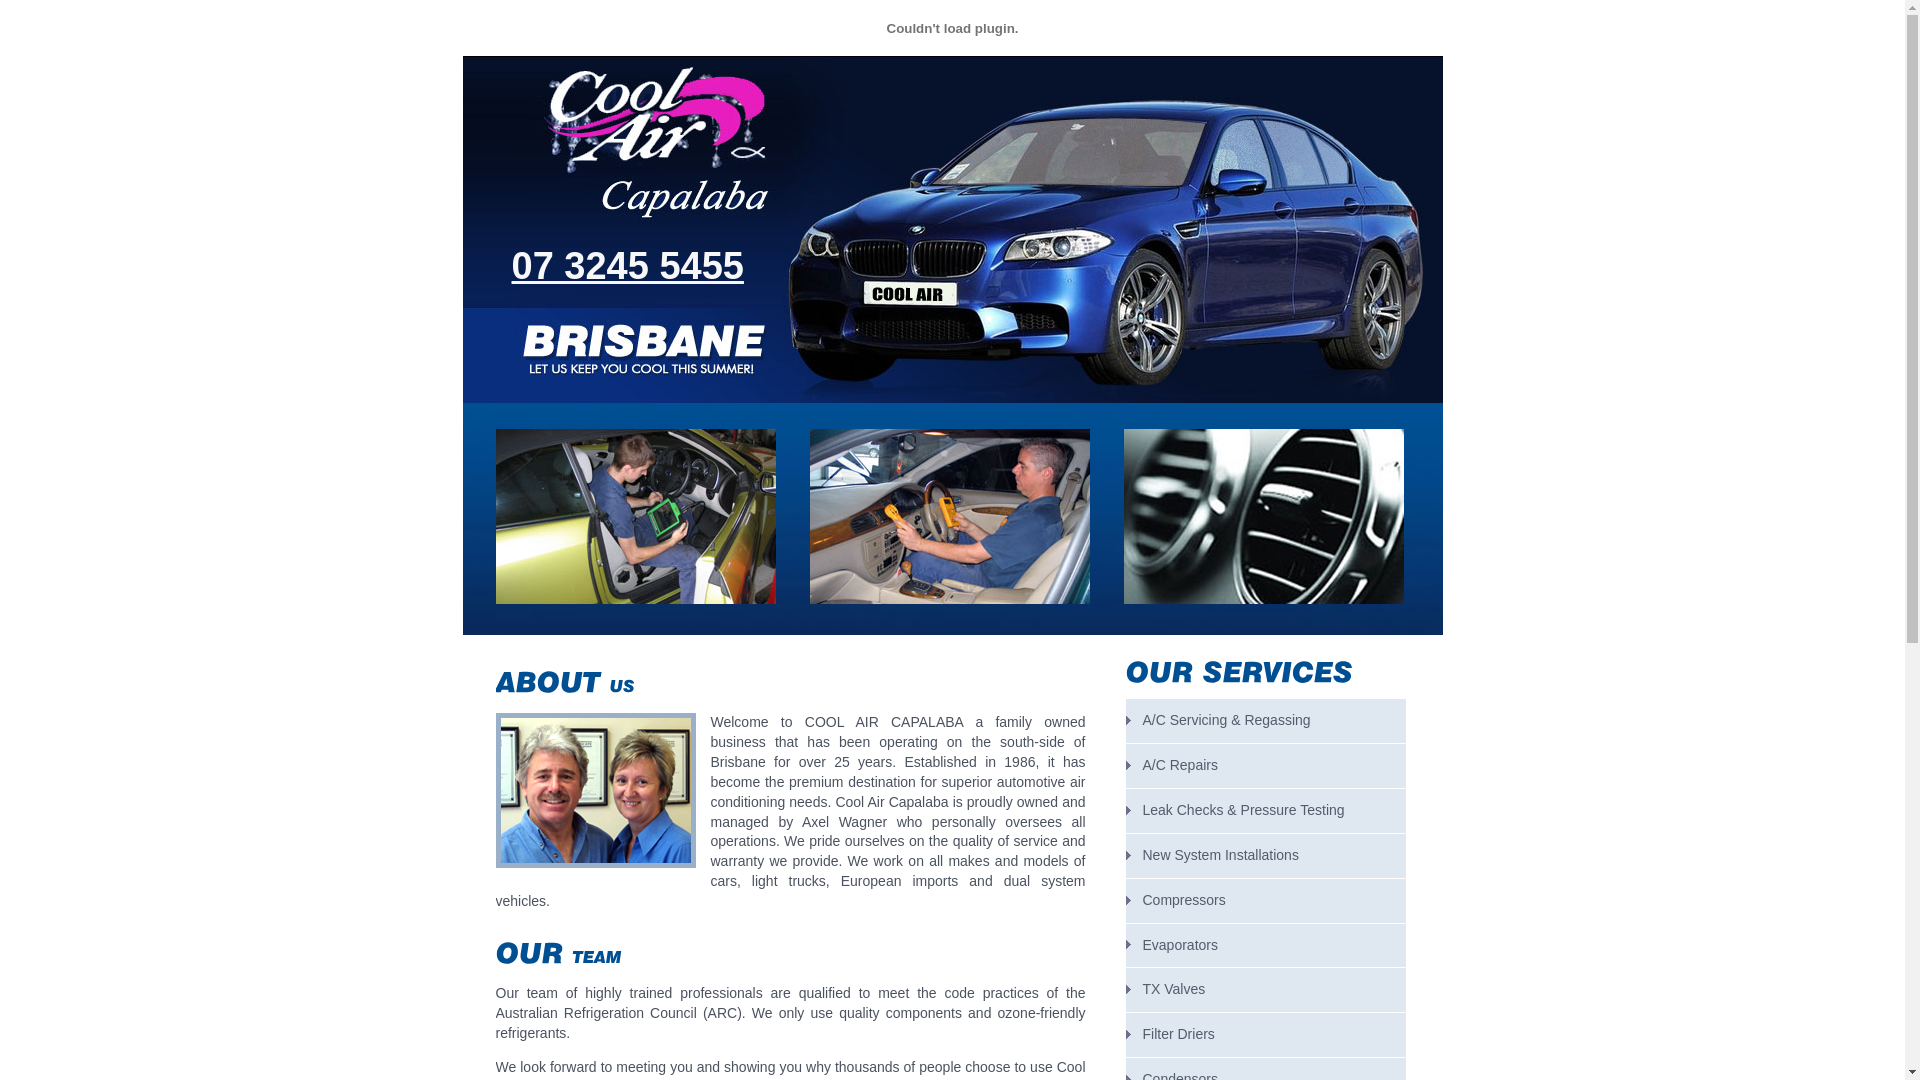

In [5]:
import PIL.Image as Image
images_folder = 'data/seeclick/seeclick_web_imgs'
filename = f"{images_folder}/{data[0]['image']}"
Image.open(filename)

In [16]:
Image.open(filename).width, Image.open(filename).height

(1920, 1080)

In [8]:
len(data[0]['conversations'])

28

In [34]:
print(len(data[0]['conversations']))
for conv in data[0]['conversations']:
    print(conv)
    print('---')

28
{'from': 'human', 'value': "<image>\nClick on 'Cool Air Capalaba'"}
---
{'from': 'gpt', 'value': 'pyautogui.click(x=0.6583, y=0.4782)', 'recipient': 'os', 'end_turn': True}
---
{'from': 'human', 'value': "Drag to select 'Filter Driers'"}
---
{'from': 'gpt', 'value': 'pyautogui.moveTo(x=0.5865, y=0.9583)\npyautogui.dragTo(x=0.7323, y=0.9583)', 'recipient': 'os', 'end_turn': True}
---
{'from': 'human', 'value': "Double-click on 'A/C Repairs'"}
---
{'from': 'gpt', 'value': 'pyautogui.doubleClick(x=0.6594, y=0.7093)', 'recipient': 'os', 'end_turn': True}
---
{'from': 'human', 'value': "Move to 'Cool Air Capalaba'"}
---
{'from': 'gpt', 'value': 'pyautogui.moveTo(x=0.4948, y=0.4782)', 'recipient': 'os', 'end_turn': True}
---
{'from': 'human', 'value': "Drag to select 'Evaporators'"}
---
{'from': 'gpt', 'value': 'pyautogui.moveTo(x=0.5865, y=0.8759)\npyautogui.dragTo(x=0.7323, y=0.8759)', 'recipient': 'os', 'end_turn': True}
---
{'from': 'human', 'value': "Right-click on 'A/C Servicing & R

In [30]:
import transformers
from aguvis.constants import (
    IGNORE_INDEX,
    additional_special_tokens,
    assistant_template,
    chat_template,
    grounding_system_message,
)
from transformers import (
    Qwen2VLForConditionalGeneration,
    Qwen2VLProcessor,
)
from qwen_vl_utils import process_vision_info
import torch
model_name_or_path = "Qwen/Qwen2-VL-7B-Instruct"
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name_or_path, padding_side="right")
additional_special_tokens = tokenizer.additional_special_tokens
if "<|recipient|>" not in additional_special_tokens:
    additional_special_tokens = additional_special_tokens + ["<|recipient|>"]
if "<|diff_marker|>" not in additional_special_tokens:
    additional_special_tokens = additional_special_tokens + ["<|diff_marker|>"]
num_new_tokens = tokenizer.add_special_tokens({"additional_special_tokens": additional_special_tokens})    
print(f"Added {num_new_tokens} tokens")
min_pixels = 256 * 28 * 28
# max_pixels = 31 * 18 * 28 * 28  # 480p
max_pixels = 46 * 26 * 28 * 28  # 720p
# max_pixels = 69 * 39 * 28 * 28  # 1080p
processor = Qwen2VLProcessor.from_pretrained(model_name_or_path, min_pixels=min_pixels, max_pixels=max_pixels)    

Added 2 tokens


In [31]:
roles = {"human": "user", "gpt": "assistant", "system": "system"}
source = data[0]['conversations']

In [50]:
agent_mode = True
roles = {"human": "user", "gpt": "assistant", "system": "system"}
assistant_template = assistant_template if agent_mode else chat_template
system_message = grounding_system_message
processor.tokenizer = tokenizer
assert tokenizer.additional_special_tokens == additional_special_tokens

im_start, im_end = tokenizer.additional_special_tokens_ids[:2]
recipient_id, end_turn_id = tokenizer.additional_special_tokens_ids[-2:]
unmask_tokens_idx = [198, im_start, im_end, recipient_id, end_turn_id]

image_index = 0
# Apply prompt templates
input_ids, targets = [], []
pixel_values, image_grid_thw = None, None

if roles[source[0]["from"]] == "system":
    system_message = source[0]["value"]
    source = source[1:]

input_id, target = [], []
convs = []

# New version, use apply chat template
# Build system message for each sentence
input_id += tokenizer.apply_chat_template(
    conversation=[{"role": "system", "content": [{"type": "text", "text": system_message}]}],
    chat_template=chat_template,
)
convs.append({"role": "system", "content": [{"type": "text", "text": system_message}]})
target += [IGNORE_INDEX] * len(input_id)

for idx, conv in enumerate(source):
    # Make sure llava data can load
    try:
        role = conv["role"]
        content = conv["content"]
    except Exception:
        role = conv["from"]
        content = conv["value"]

    role = roles.get(role, role)
    
    # Count the number of <image> tokens in the content
    image_count = content.count("<image>")
    print(f"Conv:{idx} | Image count: {image_count} | role: {role} | content: {content}")
    # If there are images, add them to the content
    if image_count > 0:
        assert role == "user", "Images are only supported for user messages"
        image_placeholders = []
        for _ in range(image_count):
            image_placeholders.append({"type": "image", "image": image[image_index]})
            image_index += 1

        content = content.replace("<image>", "")
        conv = [{"role": role, "content": image_placeholders + [{"type": "text", "text": content}]}]
        convs += conv
        image_inputs, _ = process_vision_info(conv)
        templated_conv = tokenizer.apply_chat_template(
            conversation=conv, chat_template=chat_template, tokenize=False
        )
        print('with image:\n***\n', templated_conv, '\n***')
        inputs = processor(text=[templated_conv], images=image_inputs, return_tensors="pt")
        # break
        if pixel_values is None and image_grid_thw is None:
            pixel_values = inputs["pixel_values"]
            image_grid_thw = inputs["image_grid_thw"]
        else:
            pixel_values = torch.concat([pixel_values, inputs["pixel_values"]], dim=0)
            image_grid_thw = torch.concat([image_grid_thw, inputs["image_grid_thw"]], dim=0)

    else:
        if role in ["user", "system"]:
            conv = [{"role": role, "content": [{"type": "text", "text": content}]}]
        else:  # assistant
            conv = [
                {
                    "role": role,
                    "content": [{"type": "text", "text": content}],
                    "recipient": conv.get("recipient", "os"),
                    "end_turn": conv.get("end_turn", True),
                }
            ]
        convs += conv
        templated_conv = tokenizer.apply_chat_template(
            conversation=conv,
            chat_template=assistant_template,
            tokenize=False,
        )
        print('without image:\n***\n', templated_conv, '\n***')
        inputs = processor(text=[templated_conv], return_tensors="pt")
    print('-'*100)
    encode_id = inputs.input_ids[0].tolist()

    input_id += encode_id
    if role in ["user", "system"]:
        target += [IGNORE_INDEX] * len(encode_id)
    else:
        target += encode_id

assert len(input_id) == len(target), f"{len(input_id)} != {len(target)}"
for idx, encode_id in enumerate(input_id):
    if encode_id in unmask_tokens_idx:
        target[idx] = encode_id
input_ids.append(input_id)
targets.append(target)

Conv:0 | Image count: 1 | role: user | content: <image>
Click on 'Cool Air Capalaba'
with image:
***
 <|im_start|>user
<|vision_start|><|image_pad|><|vision_end|>
Click on 'Cool Air Capalaba'<|im_end|>
 
***
----------------------------------------------------------------------------------------------------
Conv:1 | Image count: 0 | role: assistant | content: pyautogui.click(x=0.6583, y=0.4782)
without image:
***
 <|im_start|>assistant<|recipient|>os
pyautogui.click(x=0.6583, y=0.4782)<|diff_marker|>
 
***
----------------------------------------------------------------------------------------------------
Conv:2 | Image count: 0 | role: user | content: Drag to select 'Filter Driers'
without image:
***
 <|im_start|>user
Drag to select 'Filter Driers'<|im_end|>
 
***
----------------------------------------------------------------------------------------------------
Conv:3 | Image count: 0 | role: assistant | content: pyautogui.moveTo(x=0.5865, y=0.9583)
pyautogui.dragTo(x=0.7323, y=0.95

In [43]:
len(targets[0]), len(input_ids[0])

(1920, 1920)

In [51]:
convs

[{'role': 'system',
  'content': [{'type': 'text',
    'text': 'You are a GUI agent. You are given a task and a screenshot of the screen. You need to perform a series of pyautogui actions to complete the task.'}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=1920x1080>},
   {'type': 'text', 'text': "\nClick on 'Cool Air Capalaba'"}]},
 {'role': 'assistant',
  'content': [{'type': 'text', 'text': 'pyautogui.click(x=0.6583, y=0.4782)'}],
  'recipient': 'os',
  'end_turn': True},
 {'role': 'user',
  'content': [{'type': 'text', 'text': "Drag to select 'Filter Driers'"}]},
 {'role': 'assistant',
  'content': [{'type': 'text',
    'text': 'pyautogui.moveTo(x=0.5865, y=0.9583)\npyautogui.dragTo(x=0.7323, y=0.9583)'}],
  'recipient': 'os',
  'end_turn': True},
 {'role': 'user',
  'content': [{'type': 'text', 'text': "Double-click on 'A/C Repairs'"}]},
 {'role': 'assistant',
  'content': [{'type': 'text',
    'text': 'pya

In [46]:
inputs["pixel_values"]

tensor([[1.9303, 1.9303, 1.9303,  ..., 2.1459, 2.1459, 2.1459],
        [1.9303, 1.9303, 1.9303,  ..., 2.1459, 2.1459, 2.1459],
        [1.9303, 1.9303, 1.9303,  ..., 2.1459, 2.1459, 2.1459],
        ...,
        [1.9303, 1.9303, 1.9303,  ..., 1.9468, 1.9468, 1.9468],
        [1.9303, 1.9303, 1.9303,  ..., 2.1459, 2.1459, 2.1459],
        [1.9303, 1.9303, 1.9303,  ..., 1.9468, 1.9468, 1.9468]])

In [47]:
inputs.input_ids[0].tolist()

[151644,
 872,
 198,
 151652,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655,
 151655

In [49]:
tokenizer.decode(inputs.input_ids[0]).count("<|image_pad|>")

1196

In [6]:
with open('data/aguvis/train/guienv.json', 'r') as f:
    data = json.load(f)

In [7]:
len(data)

327972

In [8]:
data[0]

{'image': 'C4web50k-2_184477635-split-3.jpg',
 'conversations': [{'from': 'human',
   'value': "<image>\nClick on 'Get monthly updates on new WordPress features, themes, and plugins.'"},
  {'from': 'gpt',
   'value': 'pyautogui.click(x=0.4174, y=0.4735)',
   'recipient': 'os',
   'end_turn': True}]}

In [11]:
with open('data/aguvis/train/webui350k.json', 'r') as f:
    data = json.load(f)

In [12]:
len(data)

57389

In [13]:
data[0]

{'image': '1656264904025.png',
 'conversations': [{'from': 'human', 'value': '<image>\nGet forecast'},
  {'from': 'gpt',
   'value': 'pyautogui.click(x=0.5, y=0.6963)',
   'recipient': 'os',
   'end_turn': True}]}

In [14]:
57389 + 327972 + 271121

656482

# inference

In [2]:
import argparse
from io import BytesIO
from typing import List, Literal, Optional

import requests
from PIL import Image
from qwen_vl_utils import process_vision_info
from transformers import Qwen2VLForConditionalGeneration, Qwen2VLProcessor

from src.aguvis.constants import agent_system_message, chat_template, grounding_system_message, until, user_instruction

def load_image(image_file):
    if image_file.startswith("http://") or image_file.startswith("https://"):
        response = requests.get(image_file)
        image = Image.open(BytesIO(response.content)).convert("RGB")
    else:
        image = Image.open(image_file).convert("RGB")
    return image


def load_pretrained_model(model_path):
    model = Qwen2VLForConditionalGeneration.from_pretrained(model_path)
    processor = Qwen2VLProcessor.from_pretrained(model_path)
    tokenizer = processor.tokenizer
    return model, processor, tokenizer

In [3]:
user_instruction

'Please generate the next move according to the ui screenshot, instruction and previous actions.\n\nInstruction: {overall_goal}\n\nPrevious actions:\n{previous_actions}\n'

In [5]:
import json
with open('data/aguvis/train/seeclick.json', 'r') as f:
    data = json.load(f)
images_folder = 'data/seeclick/seeclick_web_imgs' 

In [4]:
model_path = "/export/home/yutong/Github/aguvis/results/aguvis/checkpoints/Qwen2-VL-7B-Instruct-sft-stage1_web"
model, processor, tokenizer = load_pretrained_model(model_path)
model.to('cuda')
model.tie_weights()

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [31]:
filename = f"{images_folder}/{data[0]['image']}"
image = Image.open(filename).convert("RGB")   
# instruction = "Click on 'Cool Air Capalaba'"
instruction = "Double-click on 'A/C Repairs"
mode = 'grounding'
system_message = {
    "role": "system",
    "content": grounding_system_message if mode == "grounding" else agent_system_message,
}
user_message = {
    "role": "user",
    "content": [
        {"type": "image", "image": image},
        {"type": "text", "text": instruction},
    ]
}
messages = [system_message, user_message]
text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=False, chat_template=chat_template
    )
recipient_text = "<|im_start|>assistant<|recipient|>os\n"
text += recipient_text
image_inputs, _ = process_vision_info([user_message])
inputs = processor(text=[text], images=image_inputs, return_tensors="pt")
inputs = inputs.to(model.device)

In [32]:
temperature = 0.00001
max_new_tokens = 100
results = model.generate(**inputs, temperature=temperature, max_new_tokens=max_new_tokens)
cont_toks = results.tolist()[0][len(inputs.input_ids[0]) :]
text_outputs = tokenizer.decode(cont_toks, skip_special_tokens=True).strip()
print(text_outputs)

pyautogui.doubleClick(x=0.6148, y=0.7097)


In [33]:
import re

# Input string
input_string = "pyautogui.click(x=0.3396, y=0.138)"
input_string = "pyautogui.doubleClick(x=0.6148, y=0.7097)"

# Regular expression to extract x and y coordinates
pattern = r"x=(-?\d+\.?\d*), y=(-?\d+\.?\d*)"

# Search for the pattern in the string
match = re.search(pattern, input_string)

if match:
    # Extract x and y as floats
    x = float(match.group(1))
    y = float(match.group(2))
    result = {'x': x, 'y': y}
else:
    result = {'x': None, 'y': None}
print(result)


{'x': 0.6148, 'y': 0.7097}
